# Predicting Abalone age

The purpose of this notebook is to create a model that predicts the age of an abalone from its physical characterstics as accurately as possible.

Data: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Abalone)

## Import Data

In [2]:
# Import libraries
import os
import sys

# Update path for notebook location
sys.path[0] = "../"

from urllib.request import urlretrieve, urlopen

from IPython.display import display, HTML # Display functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_palette("colorblind") 
sns.set_style("darkgrid")

# Set Pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# Set remote URL for retrieval
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/'

# Set path to data
path = '../data/raw/'

# Set filenames
filename = 'abalone.data'
names = 'abalone.names'

# Check if data is present
if 'abalone.data' not in os.listdir('../data/raw'):
    urlretrieve(URL + filename, path + filename); # Download raw data
    urlretrieve(URL + names, path + names); # Download column names

In [4]:
# Read in names from text file
with open('../data/raw/abalone.names', 'r') as names:
    lines = list(names)

# Names - for now use this list
names = ['Sex', 'Length', 'Diameter', 'Height', 'WeightWhole', 
         'WeightShucked', 'WeightViscera', 'WeightShell', 'RingCount']

# Read in data
raw = pd.read_csv('../data/raw/abalone.data', names=names, header=None, sep=',');

In [5]:
raw.head()

,Sex,Length,Diameter,Height,WeightWhole,WeightShucked,WeightViscera,WeightShell,RingCount
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## EDA

In [6]:
raw.shape

(4177, 9)

In [7]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex              4177 non-null object
Length           4177 non-null float64
Diameter         4177 non-null float64
Height           4177 non-null float64
WeightWhole      4177 non-null float64
WeightShucked    4177 non-null float64
WeightViscera    4177 non-null float64
WeightShell      4177 non-null float64
RingCount        4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


The dataset has no missing values or incorrect datatypes.

### Categorical Features

#### Sex

Sex is the only categorical variable. It has 3 classes: 
- M: male
- F: female
- I: infant

In [8]:
# Convert dtype to category
#assert (raw['Sex'].dtype == 'category') | (raw['Sex'].dtype == 'object'), "dtype must be 'category' or 'object'."

Examine distribution:

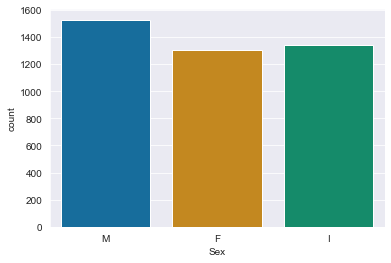

In [9]:
sns.countplot(x="Sex", data=raw);

There are 3 categories in the Sex column and the classes appear to be adequately balanced.

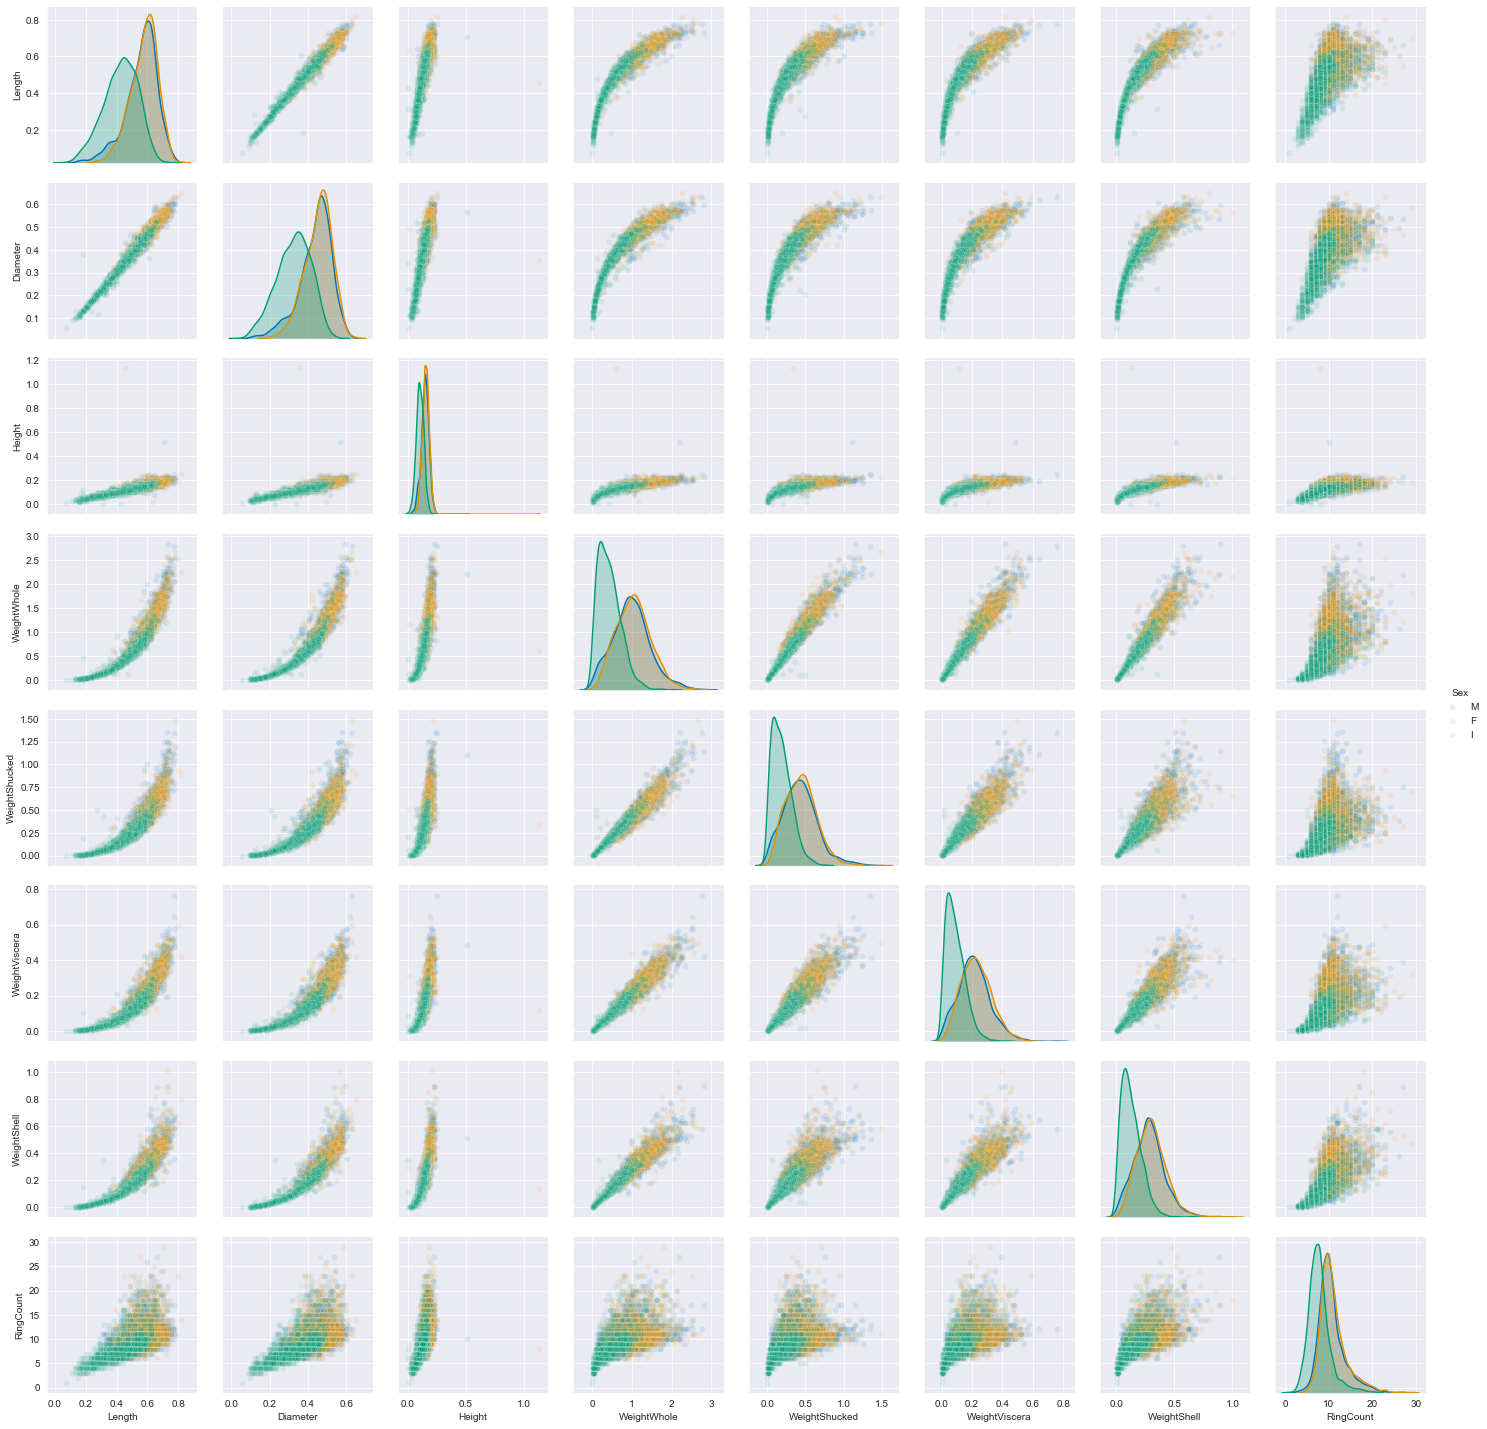

In [13]:
# Pairplots all continuous numeric features
sns.pairplot(raw, hue="Sex", diag_kind="kde", plot_kws={'alpha': 0.1});

### Numeric Features

At a glance the pairplot shows some right skew on Length and Diameter, and left skew for adult individuals on the 4 weight columns. There are also some strong correlations present among features, as well as a couple outliers in the Height column.



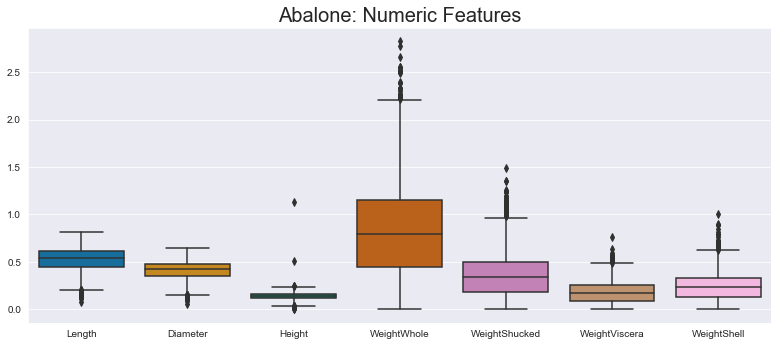

In [17]:
# Selects numeric datatypes
raw_numeric = raw.select_dtypes(include=['float64'])

# Plots boxplot of continuous numeric features
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.boxplot(data=raw_numeric, ax=ax)
plt.title("Abalone: Numeric Features", fontsize=20)
plt.tight_layout(pad=5)
plt.show()

### Discrete Numeric Features

The only feature of this type is the RingCount column, which indicates the age of the individual. This will be the target variable for the model to predict.

In [12]:
# Selects discrete numeric features
raw.select_dtypes(include='int').head()

# Plots RingCount

,RingCount
0,15
1,7
2,9
3,10
4,7


Since age is a finite variable, we can look at the number of individuals of each age:

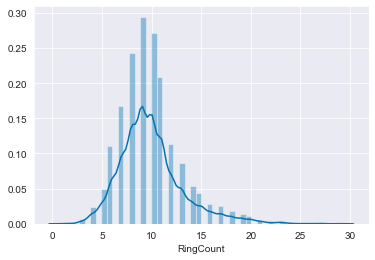

In [13]:
sns.distplot(raw["RingCount"]);

There is slight skew in the age towards younger individuals. Perhaps their probability of being harvested or eaten increases once they exceed a certain size.

## Preprocessing Methods

Models will be compared with and without the standardization and normalization steps.

**Sex** 
* Create dummies

**Length, Diameter**
* Standardize
* Remove Outliers

**Height**
* Remove Outliers with Log transform

**WeightWhole, WeightShucked, WeightViscera, WeightShell**
* Normalize

### Feature Engineering: Sex

Create dummy variables:

In [14]:
# Creates dummy variables
sex_dummies = pd.get_dummies(raw['Sex'], drop_first=True, prefix='Sex')
raw = pd.concat([raw, sex_dummies], axis=1)

### Feature Engineering: Height

A log transform will handle the outliers:

In [15]:
# Applies log transform
from sklearn.preprocessing import PowerTransformer

log = PowerTransformer(standardize=True)

log.fit(raw[['Height']])

raw['Height_log'] = log.transform(raw[['Height']])

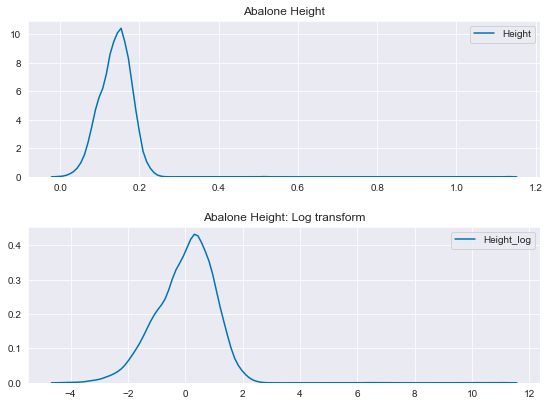

In [16]:
# Graphs different distributions before and after transform
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

sns.kdeplot(raw['Height'], ax=ax[0])
sns.kdeplot(raw['Height_log'], ax=ax[1])

ax[0].set_title('Abalone Height')
ax[1].set_title('Abalone Height: Log transform')

plt.tight_layout(pad=2)

plt.show()

### Feature Engineering: WeightWhole, WeightShucked, WeightViscera, WeightShell

Normalize values:

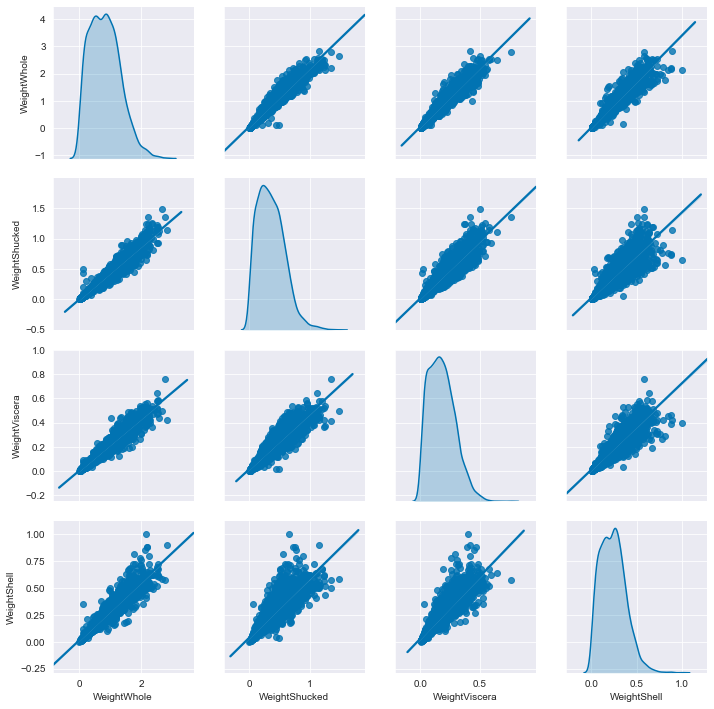

In [17]:
sns.pairplot(raw[['WeightWhole', 'WeightShucked', 'WeightViscera', 'WeightShell']], diag_kind="kde", kind="reg");

In [18]:
from sklearn.preprocessing import StandardScaler

weight_cols = ['WeightWhole', 'WeightShucked', 'WeightViscera', 'WeightShell']

ss = StandardScaler()

ss.fit(raw[weight_cols])

weight_tranformed = ss.transform(raw[weight_cols])

weight_tranformed = pd.DataFrame(weight_tranformed, columns=['Scaled_' + column for column in weight_cols])

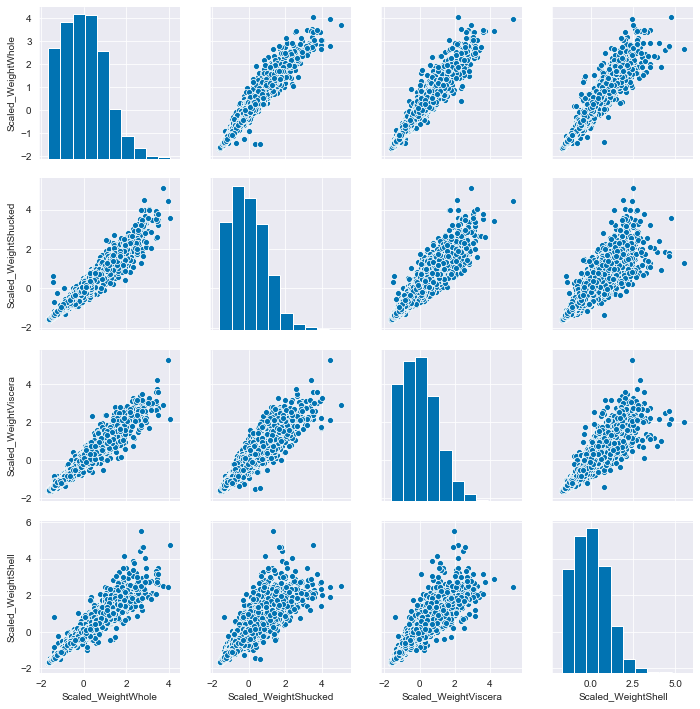

In [19]:
sns.pairplot(weight_tranformed);

In [20]:
raw = pd.concat([raw, pd.DataFrame(weight_tranformed)], axis=1)

In [21]:
# Drops unneeded columns
drop_cols = weight_cols + ['Sex', 'Height']

raw = raw.drop(drop_cols, axis=1)

In [43]:
X, y = raw.drop('RingCount', axis=1), raw['RingCount']
display(X.shape)
display(y.shape)

(4177, 9)

(4177,)

## Modeling

### Create Train & Test sets

In [44]:
from sklearn.model_selection import train_test_split

# Split test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [45]:
X_train.shape

(3341, 9)

In [46]:
y_train.shape

(3341,)

### Model: XGBoost for Classification

XGBoost comes in different flavors for classification problems. In our case we are trying to predict an age, which is a finite value that can be represented by an integer or a float aka continuous numeric. For building our model we will evaluate each of these 3 approaches:

* Multiclass using softmax objective
* Multiclass using OneVsRest approach
* Linear Regression

Parameters to adjust:
* objective={
* max_depth={

28

#### Multiclass with softmax

In [86]:
import xgboost as xgb

# Classification with softmax
xg_soft = xgb.XGBClassifier(objective="multi:softmax", n_estimators=10, seed=123, num_classes=y.nunique())

# Fits classifier to data
xg_soft.fit(X_train, y_train)

preds = xg_soft.predict(X_test)

# Accuracy score
accuracy_xg_soft = xg_soft.score(X_test, y_test)

print(accuracy_xg_soft)

0.2535885167464115


In [76]:
from sklearn.model_selection import cross_val_score

# Cross validate
cross_val_score(xg_soft, X, y, cv=5)

/Users/gregory/anaconda3/envs/uci_abalone_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


array([0.20588235, 0.28180737, 0.26530612, 0.25331725, 0.28762136])

In [ ]:
dmatrix = xgb.DMatrix(data=X, label=y)

params = {"objective"}

#### Multiclass with OneVsRest

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

# Instantiate OneVsRest
xgb_ovr = OneVsRestClassifier(XGBClassifier())

# Classification with OneVsRest
xg_onevr= xgb.XGBClassifier(objective="binary:logistic", n_estimators=7, seed=123)

# Fits classifier to data
xg_soft.fit(X_train, y_train)

# Accuracy score
xg_soft.score(X_test, y_test)

#### Logistic Regression for Integer Values

#### Visualizing Feature Importance

xgb.plot_importance(< model >, num_trees=# features, rankdir='LR')

### Model: LightGBM

### Model: Stacked Ensemble

### Model: Decision Tree

In [59]:
from sklearn.tree import DecisionTreeClassifier

# Classification with softmax
dt = DecisionTreeClassifier(max_depth=2)

# Fits classifier to data
dt.fit(X_train, y_train)

preds = dt.predict(X_test)

# Accuracy score
accuracy_dt = dt.score(X_test, y_test)

print(accuracy_dt)

0.2284688995215311


In [73]:
accuracy_dt = []

for num in range(10):
    print(num)
    dt = DecisionTreeClassifier(max_depth=num+1)
    dt.fit(X_train, y_train)
    accuracy_dt.append(dt.score(X_test, y_test))
    


0
0.1901913875598086
1
0.2284688995215311
2
0.24880382775119617
3
0.24641148325358853
4
0.2452153110047847
5
0.2535885167464115
6
0.24760765550239233
7
0.23086124401913877
8
0.2452153110047847
9
0.23086124401913877
